In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import random_split

In [2]:
class CharacterDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_folder))  # Assuming the subfolder names are the class names (A, B, C and I for empty)
        
        for label in self.classes:
            class_folder = os.path.join(root_folder, label)
            for img in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img))
                self.labels.append(ord(label) - ord('A'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        image = image.astype(np.float32) / 255.0
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 9)  # 9 classes (A-H) and empty
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
model = SimpleCNN()

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_path = ""
dataset = CharacterDataset(root_folder=dataset_path, transform=transform)


In [17]:

print(dataset.classes)
print(len(dataset.labels))
print(len(dataset.image_paths))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
5870
5870


In [18]:
# Split dataset into training and validation sets
train_size = int(0.7 * len(dataset.labels))
val_size = int(0.15 * len(dataset.labels))
test_size = len(dataset.labels) - train_size - val_size
print(f"Train Dataset Size: {train_size}")

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
val_losses = []
train_losses = []
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
for lr in np.array([0.005, 0.001, 0.0008, 0.0001]):
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)   # lr=0.0008

    # Training Loop
    num_epochs = 60
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # print(labels)
            # print(type(labels))
            # print(len(labels))
            # labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        print(f'Validation Accuracy: {100 * correct / total}%')

    print('Finished Training')

Train Dataset Size: 4109
cuda
Epoch 1, Loss: 1.998719530512196
Validation Accuracy: 39.09090909090909%
Epoch 2, Loss: 1.5169261934221252
Validation Accuracy: 64.6590909090909%
Epoch 3, Loss: 1.0429464846618415
Validation Accuracy: 74.88636363636364%
Epoch 4, Loss: 0.8184177877829056
Validation Accuracy: 81.13636363636364%
Epoch 5, Loss: 0.660154864076496
Validation Accuracy: 83.75%
Epoch 6, Loss: 0.5702575544516245
Validation Accuracy: 84.88636363636364%
Epoch 7, Loss: 0.5147771495719289
Validation Accuracy: 87.04545454545455%
Epoch 8, Loss: 0.40991533807543823
Validation Accuracy: 89.77272727272727%
Epoch 9, Loss: 0.41448142916657205
Validation Accuracy: 90.79545454545455%
Epoch 10, Loss: 0.32259129367537737
Validation Accuracy: 91.02272727272727%
Epoch 11, Loss: 0.3118983687356461
Validation Accuracy: 89.0909090909091%
Epoch 12, Loss: 0.3116214048377303
Validation Accuracy: 91.81818181818181%
Epoch 13, Loss: 0.26066181779831876
Validation Accuracy: 91.5909090909091%
Epoch 14, Loss: 0

In [8]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')


Test Accuracy: 97.50283768444949%


In [20]:
from matplotlib import pyplot as plt

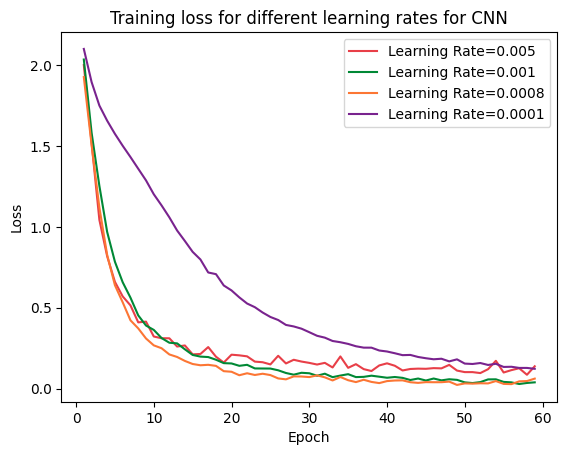

<Figure size 640x480 with 0 Axes>

In [25]:

colors = {0: (231.999/255, 63.010/255, 72.012/255), 1: (0.000, 135.992/255, 52.989/255), 2: (251.991/255, 117.989/255, 51.995/255), 3: (120.997/255, 35.011/255, 142.009/255)}
  
# [0.005, 0.001, 0.0008, 0.0001]
# Plotting training and validation losses
plt.plot(range(1, num_epochs), train_losses[0:59], label='Learning Rate=0.005', color=colors[0])
plt.plot(range(1, num_epochs), train_losses[60:119], label='Learning Rate=0.001', color=colors[1])
plt.plot(range(1, num_epochs), train_losses[120:179], label='Learning Rate=0.0008', color=colors[2])
plt.plot(range(1, num_epochs), train_losses[180:239], label='Learning Rate=0.0001', color=colors[3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss for different learning rates for CNN')
plt.legend()
plt.show()


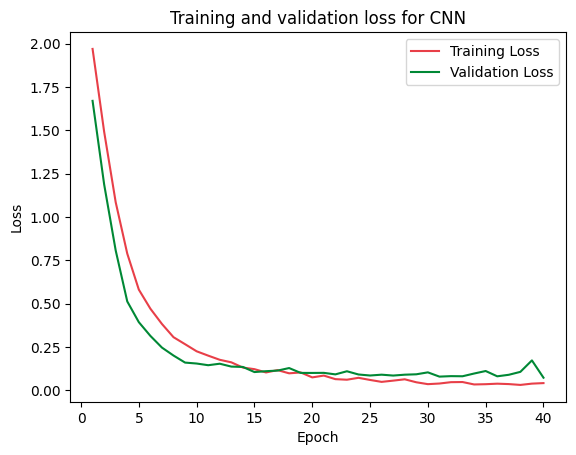

In [10]:

colors = {0: (231.999/255, 63.010/255, 72.012/255), 1: (0.000, 135.992/255, 52.989/255), 2: (251.991/255, 117.989/255, 51.995/255), 3: (120.997/255, 35.011/255, 142.009/255)}
  

# Plotting training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color=colors[0])
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss for CNN')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), 'cnn_ocr_model.pth')

In [12]:
# Use model 
# Initialize the model
test_model = SimpleCNN()

# Load the saved model state dictionary
test_model.load_state_dict(torch.load('cnn_ocr_model.pth'))
test_model.eval()  # Set the model to evaluation mode

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
# Load and preprocess the new image
image = cv2.imread('/A/image_1.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (32, 32))
image = image.astype(np.float32) / 255.0
image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = test_model(image)

# Get predicted class
_, predicted_class = torch.max(output, 1)
predicted_label = chr(predicted_class.item() + ord('A'))

print(f'Predicted Label: {predicted_label}')

Predicted Label: A
